In [1]:
# Importando las librerias necesarias
import osmnx as ox
import heapq
import pandas as pd

In [ ]:
# Crear un DataFrame a partir de un diccionario
comparacionDict = {
    'Algoritmo' : ['Dijkstra','A*'],
    'Distancia': [],
    'Numero de_Iteraciones':[],
    'Velocidad_Promedio': [],
    'Tiempo_Total': []
}

In [3]:
from geopy.geocoders import Nominatim
def get_node_coordinates(G, node_id):
    # Obtener las coordenadas geográficas del nodo
    node_data = G.nodes[node_id]
    # coordinates =   # OSMnx almacena las coordenadas en (latitud, longitud)
    return obtener_nombre_lugar(node_data['y'], node_data['x'])
# Inicializar el geocodificador
geolocator = Nominatim(user_agent="geoapiExercises")

def obtener_nombre_lugar(lat, lon):
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.address
    else:
        return "Nombre desconocido"

In [4]:
# Creando el mapa 
place_name = "La Paz, Bolivia"
# Grafo dirigido
G = ox.graph_from_place(place_name, network_type="drive")

In [5]:
# Función para convertir maxspeed a un entero
def parse_maxspeed(maxspeed):
    if isinstance(maxspeed, list):
        # Si es una lista, obtener la velocidad mínima en la lista
        speeds = []
        for speed in maxspeed:
            try:
                speeds.append(int(speed))
            except ValueError:
                # Manejar casos donde la velocidad tiene unidades como "5 mph"
                speeds.append(int(speed.split()[0]))
        return min(speeds)
    elif isinstance(maxspeed, str):
        # Manejar el caso de cadena de texto, posiblemente con unidades
        try:
            return int(maxspeed)
        except ValueError:
            # Manejar casos donde la velocidad tiene unidades como "5 mph"
            return int(maxspeed.split()[0])
    else:
        return maxspeed

# Iterar sobre las aristas para limpiar y añadir atributos
for edge in G.edges:
    # maxspeed por defecto
    maxspeed = 40
    
    # Limpiar el atributo maxspeed
    if "maxspeed" in G.edges[edge]:
        maxspeed = G.edges[edge]["maxspeed"]
        maxspeed = parse_maxspeed(maxspeed)
        
    G.edges[edge]["maxspeed"] = maxspeed
    
    # Añadir el atributo "weight" (tiempo = distancia / velocidad)
    G.edges[edge]["weight"] = G.edges[edge]["length"] / maxspeed


In [6]:
# Define Colores
def style_unvisited_edge(edge):        
    G.edges[edge]["color"] = "#00a000"
    G.edges[edge]["alpha"] = 0.2
    G.edges[edge]["linewidth"] = 0.5

def style_visited_edge(edge):
    G.edges[edge]["color"] = "#00a000"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_active_edge(edge):
    G.edges[edge]["color"] = '#00ff00'
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

def style_path_edge(edge):
    G.edges[edge]["color"] = "white"
    G.edges[edge]["alpha"] = 1
    G.edges[edge]["linewidth"] = 1

In [7]:
def plot_graph():
    ox.plot_graph(
        G,
        node_size=[G.nodes[node]["size"] for node in G.nodes],  # Tamaño de los nodos
        edge_color=[G.edges[edge]["color"] for edge in G.edges],  # Color de las aristas
        edge_alpha=[G.edges[edge]["alpha"] for edge in G.edges],  # Transparencia de las aristas
        edge_linewidth=[G.edges[edge]["linewidth"] for edge in G.edges],  # Ancho de las aristas
        node_color="white",  # Color de los nodos
        bgcolor="#18080e"  # Color de fondo del gráfico
    )


In [8]:
def dijkstra(orig, dest, plot=False):
    # Inicialización de los atributos de los nodos
    for node in G.nodes:
        G.nodes[node]["visited"] = False
        # La distancia empieza como infinita
        G.nodes[node]["distance"] = float("inf")
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
    
    for edge in G.edges:
        style_unvisited_edge(edge)
    
    # Configuración del nodo origen y destino
    # la distancia del nodo origen empieza en 0
    G.nodes[orig]["distance"] = 0
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50

    # Cola de prioridad que se iniza con la distancia y el nodo origen
    pq = [(0, orig)]
    step = 0

    cont  = 0
    # Mientras la cola de prioridad no este vacia
    while pq:
        # saca el elemento de menos prioridad
        _, node = heapq.heappop(pq)

        # Si llegamos al destino finalizamos las iteraciones 
        if node == dest:
            if plot:
                comparacionDict['Numero de_Iteraciones'].append(step)
                print("Iteraciones:", step)
                plot_graph()
            return
        # Si el nodo ya fue visitado continuamos
        if G.nodes[node]["visited"]: continue
        # marcamos el nodo como visitado
        G.nodes[node]["visited"] = True
        # Exploramos las aristas salientes
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            weight = G.edges[(edge[0], edge[1], 0)]["weight"]
             # Actualizamos la distancia si encontramos un camino más corto
            if G.nodes[neighbor]["distance"] > G.nodes[node]["distance"] + weight:
                G.nodes[neighbor]["distance"] = G.nodes[node]["distance"] + weight
                G.nodes[neighbor]["previous"] = node
                # Agrega un elmento a una cola
                heapq.heappush(pq, (G.nodes[neighbor]["distance"], neighbor))
                # Estilizamos las aristas salientes del vecino
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [9]:
def distance(node1, node2):
    x1, y1 = G.nodes[node1]["x"], G.nodes[node1]["y"]
    x2, y2 = G.nodes[node2]["x"], G.nodes[node2]["y"]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def a_star(orig, dest, plot=False):
    for node in G.nodes:
        G.nodes[node]["previous"] = None
        G.nodes[node]["size"] = 0
        G.nodes[node]["g_score"] = float("inf")
        G.nodes[node]["f_score"] = float("inf")
    for edge in G.edges:
        style_unvisited_edge(edge)
    G.nodes[orig]["size"] = 50
    G.nodes[dest]["size"] = 50
    G.nodes[orig]["g_score"] = 0
    G.nodes[orig]["f_score"] = distance(orig, dest)
    pq = [(G.nodes[orig]["f_score"], orig)]
    step = 0
    while pq:
        _, node = heapq.heappop(pq)
        if node == dest:
            if plot:
                comparacionDict['Numero de_Iteraciones'].append(step)
                print("Iteraciones:", step)
                plot_graph()
            return
        for edge in G.out_edges(node):
            style_visited_edge((edge[0], edge[1], 0))
            neighbor = edge[1]
            tentative_g_score = G.nodes[node]["g_score"] + distance(node, neighbor)
            if tentative_g_score < G.nodes[neighbor]["g_score"]:
                G.nodes[neighbor]["previous"] = node
                G.nodes[neighbor]["g_score"] = tentative_g_score
                G.nodes[neighbor]["f_score"] = tentative_g_score + distance(neighbor, dest)
                heapq.heappush(pq, (G.nodes[neighbor]["f_score"], neighbor))
                for edge2 in G.out_edges(neighbor):
                    style_active_edge((edge2[0], edge2[1], 0))
        step += 1

In [10]:

def reconstruct_path(orig, dest, plot=False, algorithm=None):
    for edge in G.edges:
        style_unvisited_edge(edge)
    dist = 0
    speeds = []
    curr = dest
    while curr != orig:
        prev = G.nodes[curr]["previous"]
        dist += G.edges[(prev, curr, 0)]["length"]
        speeds.append(G.edges[(prev, curr, 0)]["maxspeed"])
        style_path_edge((prev, curr, 0))
        if algorithm:
            G.edges[(prev, curr, 0)][f"{algorithm}_uses"] = G.edges[(prev, curr, 0)].get(f"{algorithm}_uses", 0) + 1
        curr = prev
    dist /= 1000
    if plot:
        distString = str(f"{dist:.2f}") + 'km'
        velocidadPromString = str(f"{sum(speeds)/len(speeds):.2f}") + 'km'
        tiempoString = str(f"{dist/(sum(speeds)/len(speeds)) * 60:.2f}") + 'min'
        comparacionDict['Distancia'].append(distString)
        comparacionDict['Velocidad_Promedio'].append(velocidadPromString)
        comparacionDict['Tiempo_Total'].append(tiempoString)
        print(f"Distance: {dist}")
        print(f"Avg. speed: {sum(speeds)/len(speeds)}")
        print(f"Total time: {dist/(sum(speeds)/len(speeds)) * 60}")
        plot_graph()

In [11]:
def get_nearest_node(G, place_name):
    # Obtener las coordenadas geográficas del lugar
    geocode_result = ox.geocode(place_name)
    # Encontrar el nodo más cercano a las coordenadas en el grafo G
    nearest_node = ox.distance.nearest_nodes(G, X=geocode_result[1], Y=geocode_result[0])
    return nearest_node

Iteraciones: 10224


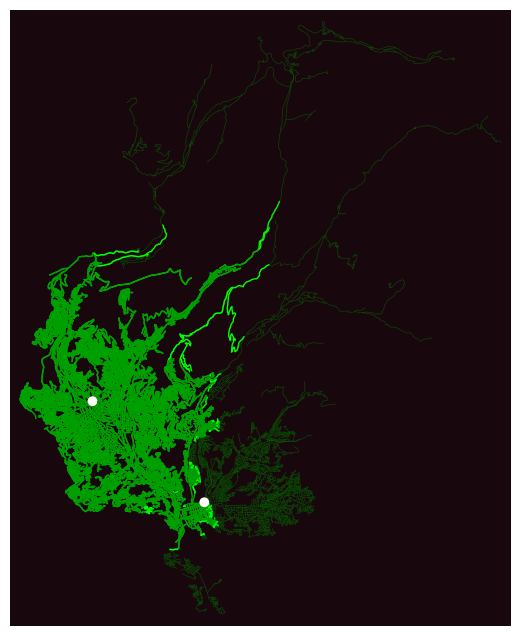

Distance: 9.954989000000003
Avg. speed: 39.7752808988764
Total time: 15.016847813559329


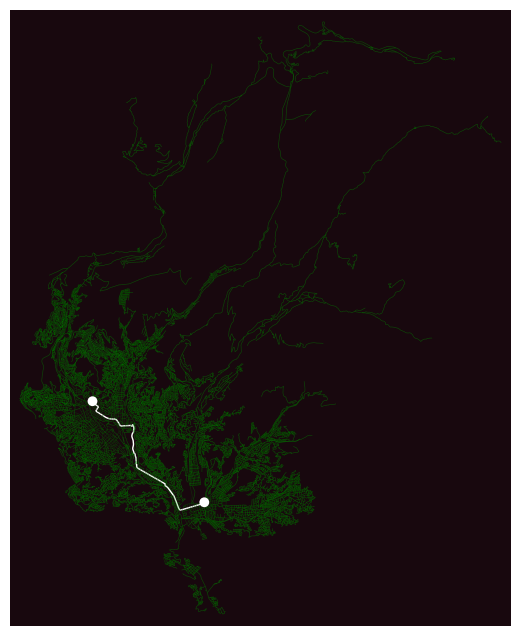

Iteraciones: 2602


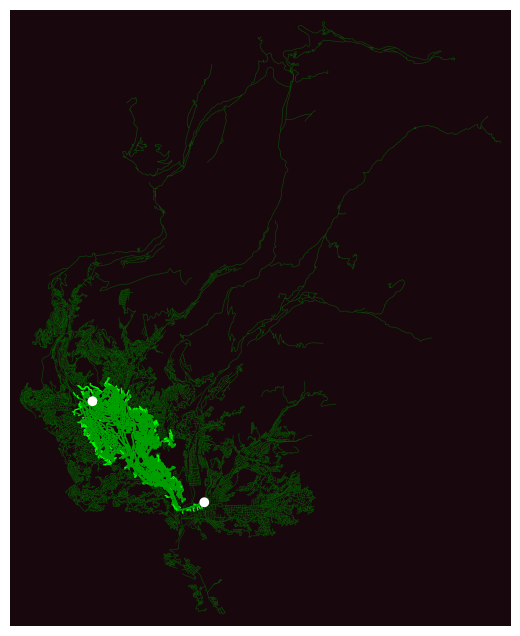

Distance: 9.693717000000005
Avg. speed: 38.888888888888886
Total time: 14.956020514285724


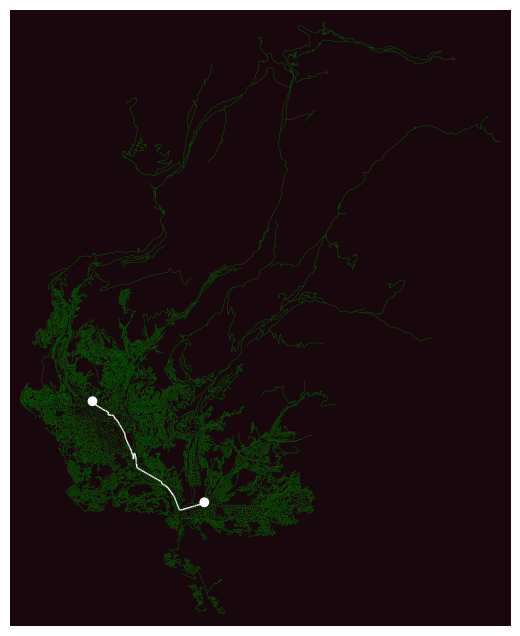

  Algoritmo Distancia  Numero de_Iteraciones Velocidad_Promedio Tiempo_Total
0  Dijkstra    9.95km                  10224            39.78km     15.02min
1  A*          9.69km                   2602            38.89km     14.96min


In [12]:
start_place = "plaza riosinho"
# end_place = "Aeropuerto Internacional El Alto"
end_place = "Green Tower, la paz"

# Obtener los nodos más cercanos a estos lugares
start = get_nearest_node(G, start_place)
end = get_nearest_node(G, end_place)

dijkstra(start, end, plot=True)
reconstruct_path(start, end, plot=True)
a_star(start, end, plot=True)
reconstruct_path(start, end, plot=True)
df = pd.DataFrame(comparacionDict)
print(df)

Iteraciones: 3238


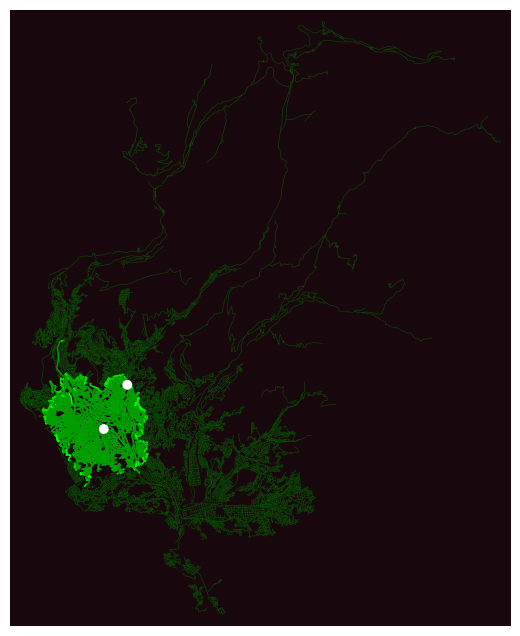

Distance: 3.626172999999999
Avg. speed: 40.0
Total time: 5.439259499999999


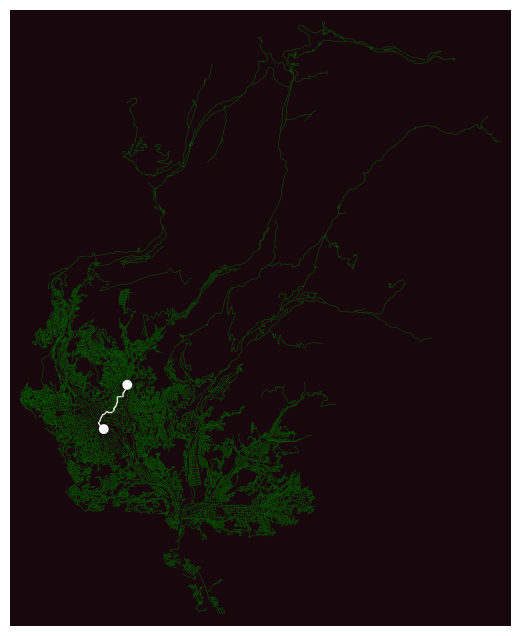

Iteraciones: 450


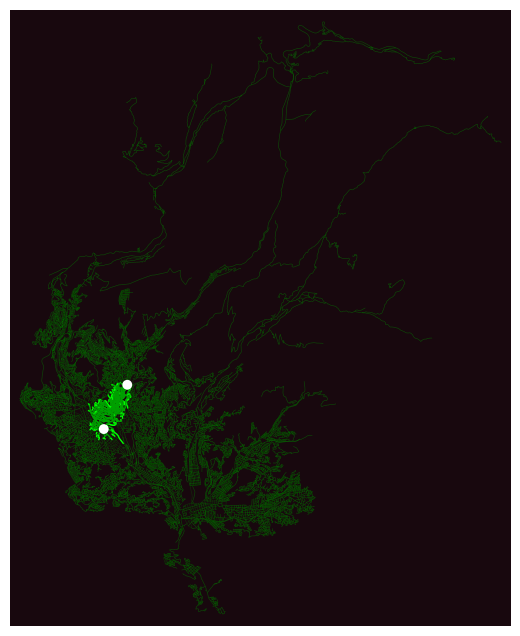

Distance: 3.626641
Avg. speed: 40.0
Total time: 5.4399615


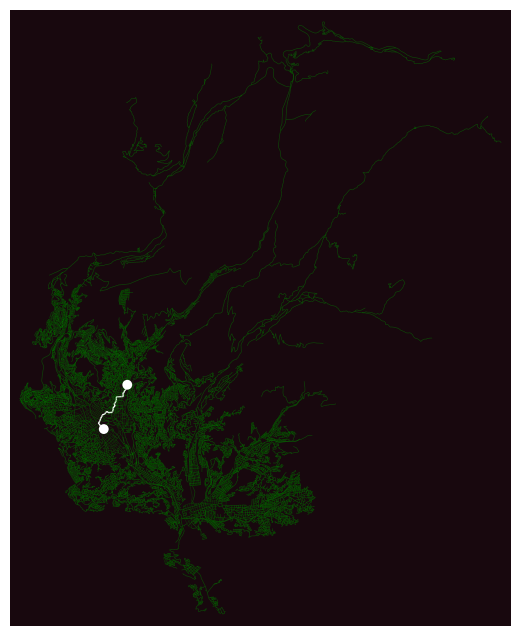

  Algoritmo Distancia  Numero de_Iteraciones Velocidad_Promedio Tiempo_Total
0  Dijkstra    3.63km                   3238            40.00km      5.44min
1     A*       3.63km                    450            40.00km      5.44min


In [18]:
comparacionDict = {
    'Algoritmo' : ['Dijkstra','A*   '],
    'Distancia': [],
    'Numero de_Iteraciones':[],
    'Velocidad_Promedio': [],
    'Tiempo_Total': []
}

start_place = "Monoblock Central UMSA"
end_place = "Jose Maria Perez"

# Obtener los nodos más cercanos a estos lugares
start = get_nearest_node(G, start_place)
end = get_nearest_node(G, end_place)

dijkstra(start, end, plot=True)
reconstruct_path(start, end, plot=True)
a_star(start, end, plot=True)
reconstruct_path(start, end, plot=True)
df = pd.DataFrame(comparacionDict)
print(df)